# Building Damage Assessment - XGBoost
This notebook use XGBoost to classify building damage based on a subset of 4 million pixels from the extracted NAIP images. The model was trained on Google Colab 

## Set up and Load Data

### Google Drive & Path

In [0]:
from google.colab import drive # import drive from google colab
ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd "/content/drive/My Drive/FinalProj"
%ls "./Data/FireDataset/train"

### Prepare Packages

In [0]:
!pip install rasterio

     |████████████████████████████████| 18.2MB 28.8MB/s 


In [0]:
!pip install geopandas

     |████████████████████████████████| 931kB 5.8MB/s 
     |████████████████████████████████| 10.9MB 177kB/s 
     |████████████████████████████████| 14.7MB 210kB/s 


In [0]:
!pip install imagecodecs
!pip install tifffile
#need to upgrade to read compressed tiff in Colab
!pip install --upgrade scikit-image

     |████████████████████████████████| 17.9MB 171kB/s 
     |████████████████████████████████| 12.4MB 250kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2


In [0]:
!pip install eli5

     |████████████████████████████████| 112kB 6.6MB/s 


In [0]:
!pip install yellowbrick

In [0]:
!pip install shap

     |████████████████████████████████| 276kB 5.9MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394132 sha256=254516e1c9b933a8e5a3ec30c316ca1369e01d05088d5e2879dd1e46cbfea2fb
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


## Load packages and data

In [0]:
from skimage import io
import imagecodecs
import os, fnmatch,tifffile
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import model_selection
import matplotlib.image as mpimg



In [0]:
# retrieve file path + names based on extension
def lstFiles(rootPath, ext):
    file_list = []
    root = rootPath
    for path, subdirs, files in os.walk(root):
        for names in files: 
            if names.endswith(ext) and not names.startswith("._"):
                file_list.append(path  +"/" + names)
    return(file_list)


# get merged all test/train dataset
merged_path = "./Data/FireDataset/merged_shp"
merged_files = lstFiles(merged_path, '.shp')
gdf = gpd.read_file(merged_files[0])
santaRosa = gdf.query("location_n == 'santa-rosa-wildfire'")
ID_list=santaRosa.ID.unique()

In [0]:
#get files by match pattern
def find(pattern, path):
    '''
    #find names of files that match the pattern
    args:
    pattern: string to be matched
    path: path of files
    '''
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

### Get Data for Training
Use a subset of 4 million pixels * 43 features for training due to the data size limitations from Google Colab

In [0]:
folder='./NAIP_img_new/'
#the number of features (including ground truth layer)
n_feature=44
data=np.empty(shape=(0,n_feature),dtype='float')
#counter=0
#combine all pre post images together
#for index in ID_list:
#test on a subset
for index in ID_list[:10]:
    #files=find('*'+index+'*.tif', folder) # data not returned in desired order for each index
    #pre
    img=io.imread(folder+'pre_'+index+'.tif')
    gt=io.imread(folder+'pre_'+index+'gt.tif')
    img=np.concatenate((img,gt[:,:,None]),axis=2)
    img=np.reshape(img,(img.shape[0]*img.shape[1],img.shape[2]))
    data=np.concatenate((data,img),axis=0)
    #post
    img=io.imread(folder+'post_'+index+'.tif')
    gt=io.imread(folder+'post_'+index+'gt.tif')
    img=np.concatenate((img,gt[:,:,None]),axis=2)
    img=np.reshape(img,(img.shape[0]*img.shape[1],img.shape[2]))
    data=np.concatenate((data,img),axis=0)
    #counter+=1
    #if counter%50==0:
        #print(index+'concatenated!')



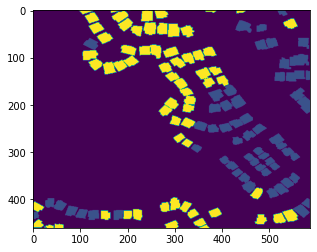

In [0]:
plt.imshow(gt)

## XGBoost
- Model Performance
- Feature Evaluation

### Tune XGBoost

In [0]:
features=['R', 'G', 'B', 'N', 'NDVI', 'edge', 'BSI', 'SI', 'texture', 'R_contrast', 'N_contrast', 'R_corr', 'G_corr', 'B_corr', 'N_corr', 'R_var', 'N_var', 'R_idm', 'G_idm', 'B_idm', 'N_idm', 'R_diss', 'N_diss', 'R_shade', 'G_shade', 'B_shade', 'N_shade', 'R_gauss', 'G_gauss', 'B_gauss', 'N_gauss', 'R_low_oct', 'G_low_oct', 'B_low_oct', 'N_low_oct', 'R_manha', 'G_manha', 'B_manha', 'N_manha', 'KMeans', 'KMeans_Seg', 'SNIC', 'LVQ']

In [0]:
features.append('y')
len(features)

44

In [0]:
data=pd.DataFrame(data,columns=features)
X=data.iloc[:,:-1]
y=data['y']
#group y from 5 classes to 3 classes: 0: non building 1: undestroyed and 2: destroyed (remove minor and major imacts due to the limited samples)
y[y>=2]=2
y=y.astype('int')

In [0]:
#split training and testing sets
train_X, val_X, train_y, val_y = model_selection.train_test_split(X, y,test_size=0.5,shuffle=True, random_state=23)

### Gridsearch

In [0]:
#the data is too large and time consuming to tune with gridsearch due to the RAM size of Colab (~4 million pixels), randomly use 10% to tune the model
train_X, _, train_y, _ = model_selection.train_test_split(train_X, train_y,test_size=0.9,shuffle=True, random_state=23) 

In [0]:
#The total iteration would be 3*4*3*2*3*3*2*2*2=5184, so seperate the tuning process to save time
param_grid = { 
    'n_estimators': [10,100,500],
    'learning_rate':[0.01,0.05,0.1,1,10],
    'max_depth' : [5,10,20],
    'min_child_weight': [0.5,1],
    'gamma':[0,0.5,1],
    'alpha':[0,0.5,1],
    'subsample': [1,3],
    'colsample_bytree': [0.5,1],
    'eta':[0.5,1],
    
}

First, tune n_estimators and learning_rate

In [0]:
param_grid = { 
    'n_estimators': [10,100,500],
    'learning_rate':[0.01,0.05,0.1,1,10],
}

searchCV = model_selection.GridSearchCV(estimator=xgb.XGBClassifier(tree_method = "gpu_hist"), cv=5,
                        param_grid=param_grid,
                        #enable train score (however, this can be time-consuming)
                        n_jobs=-1,return_train_score=False)

#train,eval split
#split_value=int(0.5*len(train_X))
#split training and testing sets
tr_X, v_X, tr_y, v_y = model_selection.train_test_split(train_X, train_y,test_size=0.2,shuffle=True, random_state=23)
searchCV.fit(tr_X, tr_y,eval_set=[(v_X, v_y)],early_stopping_rounds=10,verbose=False)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 1, 10],
                         'n_estimators': [10, 100,

In [0]:
#return the best n_neighbors
CV_result=pd.DataFrame(searchCV.cv_results_)
print('The best performing parameter:',searchCV.best_params_) 

The best performing parameter: {'learning_rate': 1, 'n_estimators': 500}


Then, tune depth and child weight

In [0]:
param_grid = { 
    'max_depth' : [5,10,20],
    'min_child_weight': [0.5,1],
}
searchCV = model_selection.GridSearchCV(estimator=xgb.XGBClassifier(tree_method = "gpu_hist",learning_rate=1,n_estimators=500), cv=5,
                        param_grid=param_grid,
                        #enable train score (however, this can be time-consuming)
                        n_jobs=-1,return_train_score=False)

#train,eval split
#split_value=int(0.5*len(train_X))
#split training and testing sets
#tr_X, v_X, tr_y, v_y = model_selection.train_test_split(train_X, train_y,test_size=0.2,shuffle=True, random_state=23)
searchCV.fit(tr_X, tr_y,eval_set=[(v_X, v_y)],early_stopping_rounds=10,verbose=False)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=500, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'min_child_weight': [0.5, 1]},
             

In [0]:
print('The best performing parameter:',searchCV.best_params_) 

The best performing parameter: {'max_depth': 10, 'min_child_weight': 0.5}


tune the regularization terms


In [0]:
param_grid = { 
    'gamma':[0,0.5,1],
    'alpha':[0,0.5,1]
}
searchCV = model_selection.GridSearchCV(estimator=xgb.XGBClassifier(tree_method = "gpu_hist",learning_rate=1,n_estimators=500,max_depth=10,min_child_weight=0.5), cv=5,
                        param_grid=param_grid,
                        #enable train score (however, this can be time-consuming)
                        n_jobs=-1,return_train_score=False)

#train,eval split
#split_value=int(0.5*len(train_X))
#split training and testing sets
#tr_X, v_X, tr_y, v_y = model_selection.train_test_split(train_X, train_y,test_size=0.2,shuffle=True, random_state=23)
searchCV.fit(tr_X, tr_y,eval_set=[(v_X, v_y)],early_stopping_rounds=10,verbose=False)
print('The best performing parameter:',searchCV.best_params_) 

The best performing parameter: {'alpha': 0, 'gamma': 0}


Next, tune subsample, eta, and coksample by tree

In [0]:
param_grid = { 
    'subsample': [1,3],
    'colsample_bytree': [0.5,1],
    'eta':[0.5,1]  
}
searchCV = model_selection.GridSearchCV(estimator=xgb.XGBClassifier(tree_method = "gpu_hist",learning_rate=1,n_estimators=500,max_depth=10,min_child_weight=0.5,alpha=0,gamma=0), cv=5,
                        param_grid=param_grid,
                        #enable train score (however, this can be time-consuming)
                        n_jobs=-1,return_train_score=False)

#train,eval split
#split_value=int(0.5*len(train_X))
#split training and testing sets
#tr_X, v_X, tr_y, v_y = model_selection.train_test_split(train_X, train_y,test_size=0.2,shuffle=True, random_state=23)
searchCV.fit(tr_X, tr_y,eval_set=[(v_X, v_y)],early_stopping_rounds=10,verbose=False)
print('The best performing parameter:',searchCV.best_params_) 

The best performing parameter: {'colsample_bytree': 1, 'eta': 0.5, 'subsample': 1}


### Fit the Model

In [0]:
#split training and testing sets
train_X, val_X, train_y, val_y = model_selection.train_test_split(X, y,test_size=0.5,shuffle=True, random_state=23)

In [0]:
#gbc=xgb.XGBClassifier(n_estimators=500,learning_rate=1,tree_method = "gpu_hist")
gbc=xgb.XGBClassifier(tree_method = "gpu_hist",n_estimators=500,learning_rate=1,max_depth=10,min_child_weight=0.5,gamma=0,alpha=0,subsample=1,colsample_bytree=1,eta=0.5)
#gbc.fit(train_X,train_y)

#fit on all training data
gbc.fit(X,y)

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.5, gamma=0,
              learning_rate=1, max_delta_step=0, max_depth=10,
              min_child_weight=0.5, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

## Model Accuracy and Evaluation

### Accuracy

In [0]:
from sklearn import metrics

In [0]:
# get some test data
folder='./NAIP_img_new/'
#the number of features
n_feature=44
data_test=np.empty(shape=(0,n_feature),dtype='float')
shapes=[]
#counter=0
#combine all pre post images together
#for index in ID_list:
#test on a subset
for index in ID_list[10:15]:
    #files=find('*'+index+'*.tif', folder) # data not returned in desired order for each index
    #pre
    img=io.imread(folder+'pre_'+index+'.tif')
    gt=io.imread(folder+'pre_'+index+'gt.tif')
    img=np.concatenate((img,gt[:,:,None]),axis=2)
    shapes.append(img.shape)
    img=np.reshape(img,(img.shape[0]*img.shape[1],img.shape[2]))
    data_test=np.concatenate((data_test,img),axis=0)
    #post
    img=io.imread(folder+'post_'+index+'.tif')
    gt=io.imread(folder+'post_'+index+'gt.tif')
    img=np.concatenate((img,gt[:,:,None]),axis=2)
    shapes.append(img.shape)
    img=np.reshape(img,(img.shape[0]*img.shape[1],img.shape[2]))
    data_test=np.concatenate((data_test,img),axis=0)
    #if counter%50==0:
        #print(index+'concatenated!')

In [0]:
data_test=pd.DataFrame(data_test,columns=features)
X_te=data_test.iloc[:,:-1]

In [0]:
y_te=data_test['y']
#group y from 5 classes to 3 classes: 0: non building 1: undestroyed and 2: destroyed (remove minor and major imacts due to the limited samples)
y_te[y_te>=2]=2
y_te=y_te.astype('int')

In [0]:
#predict
#pred_y=gbc.predict(val_X)
#print('The accuracy and weighted f1 score for xgboost with best parameters are: ',metrics.accuracy_score(val_y,pred_y),' and ',metrics.f1_score(val_y,pred_y,average='weighted'))
#predict on the test set
pred_y=gbc.predict(X_te)
print('The accuracy and weighted f1 score for xgboost with best parameters are: ',metrics.accuracy_score(y_te,pred_y),' and ',metrics.f1_score(y_te,pred_y,average='weighted'))

The accuracy and weighted f1 score for xgboost with best parameters are:  0.9085204450668678  and  0.8848609580119121


In [0]:
print('The cohen Kappa is: ',metrics.cohen_kappa_score(y_te,pred_y),' and ',metrics.balanced_accuracy_score(y_te,pred_y))

The cohen Kappa is:  0.18875664451922114  and  0.4061697233526886


In [0]:
cm=metrics.confusion_matrix(y_te, pred_y, labels=[0,1,2])
print('Confusion Matrix')
print(cm)

Confusion Matrix
[[931328  12475   1417]
 [ 74612  12606    243]
 [  6311     50    622]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


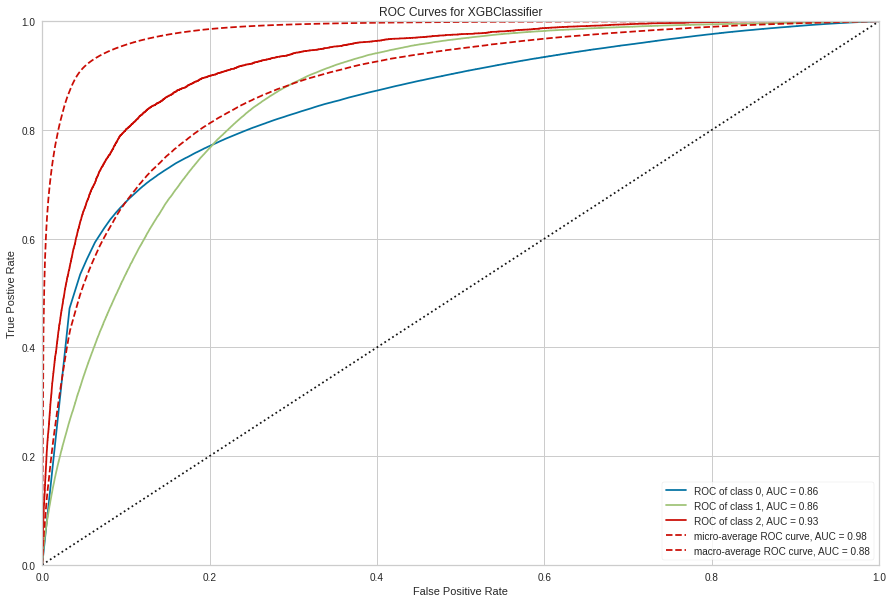

In [0]:
from yellowbrick.classifier import ROCAUC
classes=[0,1,2]
rocauc = ROCAUC(gbc, size=(1080, 720), classes=classes)

rocauc.score(X_te, y_te)  
r = rocauc.poof()

__Results Interpretation__
The overall accuracy of the XGBoost model is 90.8%, although it is slightly lower than the accuracy of Neural Network (See NN notebook), it actually works better than the deep neural net as it has a balanced accuracy of 40.6%. Overall, the classification didn't show a good agreement with the ground truth with a Kappa of 0.18. The confusion matrix also showed that for no-damage and destroyed buildings, most of them were labeled as no-building. The ROC curve shows that the class 2 (destroyed buildings) seems to be more acurate, being closer to the ideal clinical discriminator (upper-left border).

### Prediction and Visualization

In [0]:
def pred_visual(folder,index,state,features):
    '''
    This function takes one image, calculate the testing score on the image and visualize predictions
    folder: the folder (relative) to access the image
    index: string, image id: 00000XXX
    state: string, pre or post
    features: list of string, names of features
    '''
    img=io.imread(folder+state+'_'+index+'.tif')
    gt=io.imread(folder+state+'_'+index+'gt.tif')
    gt[gt>=2]=2
    shapes=img.shape
    #add ground truth as the last band
    img_data=np.concatenate((img,gt[:,:,None]),axis=2)
    img_data=np.reshape(img_data,(shapes[0]*shapes[1],(shapes[2]+1)))

    #organize dataframe
    img_data=pd.DataFrame(img_data,columns=features)
    X_te=img_data.iloc[:,:-1]
    y_te=img_data['y']
    #group y from 5 classes to 3 classes: 0: non building 1: undestroyed and 2: destroyed (remove minor and major imacts due to the limited samples)
    y_te[y_te>=2]=2
    y_te=y_te.astype('int')
    pred_y=gbc.predict(X_te)
    print('The accuracy and Kappa for this image are: ',metrics.accuracy_score(y_te,pred_y),' and ',metrics.cohen_kappa_score(y_te,pred_y))
    pred_image=np.reshape(pred_y,(shapes[0],shapes[1]))

    #show images
    _, axs = plt.subplots(1, 3, figsize=(11, 12))
    axs = axs.flatten()
    #for img, ax in zip([np.uint8(img[:,:,:3]),gt,pred_image], axs):
    for img, ax in zip([img[:,:,:3]/255,gt,pred_image],axs):
        ax.grid(False)
        ax.imshow(img,vmin=0, vmax=2,cmap='brg')
    plt.show() 

Pre fire prediction:
The accuracy and Kappa for this image are:  0.9865326553313205  and  0.10523767220012603


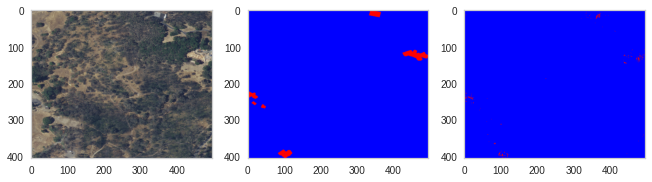

In [0]:
folder=folder='./NAIP_img_new/'
index='00000081'
state='pre'
print('Pre fire prediction:')
pred_visual(folder,index,state,features=features)

Post fire prediction:
The accuracy and Kappa for this image are:  0.9863191244239631  and  0.05988360611910748


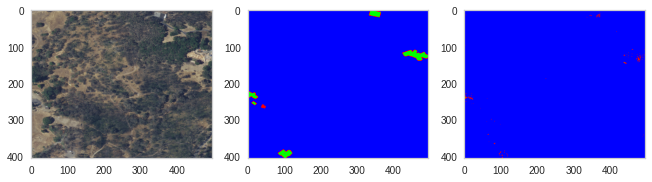

In [0]:
folder=folder='./NAIP_img_new/'
index='00000081'
state='post'
print('Post fire prediction:')
pred_visual(folder,index,state,features=features)

Pre fire prediction:
The accuracy and Kappa for this image are:  0.9276632923596048  and  0.18122630775435633


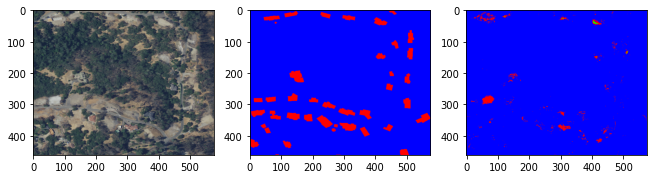

In [0]:
folder=folder='./NAIP_img_new/'
index='00000220'
state='pre'
print('Pre fire prediction:')
pred_visual(folder,index,state,features=features)

Post fire prediction:
The accuracy and Kappa for this image are:  0.9237994094962642  and  0.12363044175970284


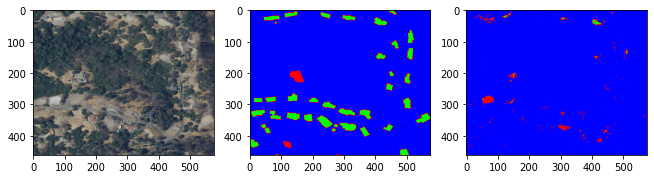

In [0]:
folder=folder='./NAIP_img_new/'
index='00000220'
state='post'
print('Post fire prediction:')
pred_visual(folder,index,state,features=features)

Pre fire prediction:
The accuracy and Kappa for this image are:  0.9317573914566384  and  0.21089768079200133


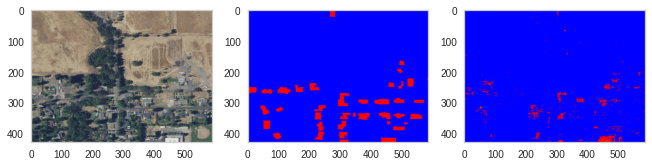

In [0]:
folder=folder='./NAIP_img_new/'
index='00000376'
state='pre'
print('Pre fire prediction:')
pred_visual(folder,index,state,features=features)

Post fire prediction:
The accuracy and Kappa for this image are:  0.9317007431979841  and  0.18840260184778357


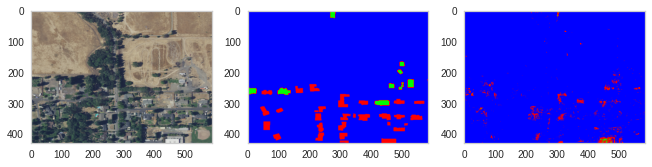

In [0]:
folder=folder='./NAIP_img_new/'
index='00000376'
state='post'
print('Post fire prediction:')
pred_visual(folder,index,state,features=features)

__Results Interpretation__
The classification results visualized above showed that XGBoost is able to, at least partially, differentiate building footprints from the background. However, it is hard to capture the total shape of the buildings. Moreover, it can only differentiate very little amount of destroyed buildings from the no-damage buildings.

## Feature Analysis
- Feature Importance (Gini and Permutation)
- Predictability of Features (Shapley Additive Explanations)

### Feature Importance

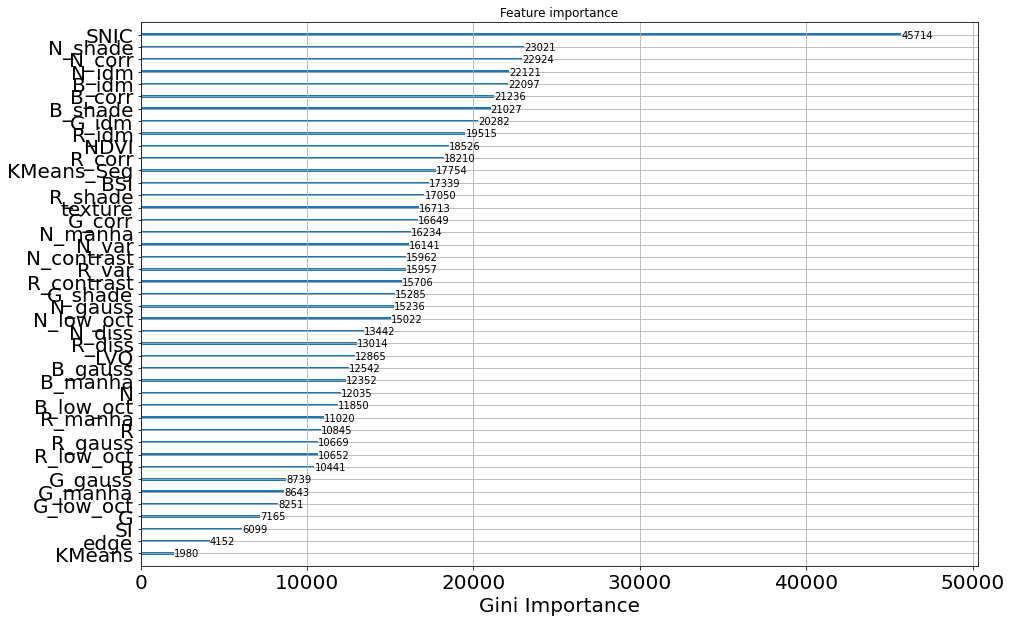

In [0]:
fig, ax = plt.subplots()
xgb.plot_importance(gbc,ax=ax)
#fig = plt.gcf()
#fig.set_size_inches(150, 100)
ax.set_xlabel(xlabel='Gini Importance',fontsize=20)
ax.set_ylabel(ylabel='',fontsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
fig.set_size_inches(15, 10)

In [0]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(gbc, random_state=23).fit(train_X,train_y)
eli5.show_weights(gbc, feature_names = X.columns.tolist(),top=45)

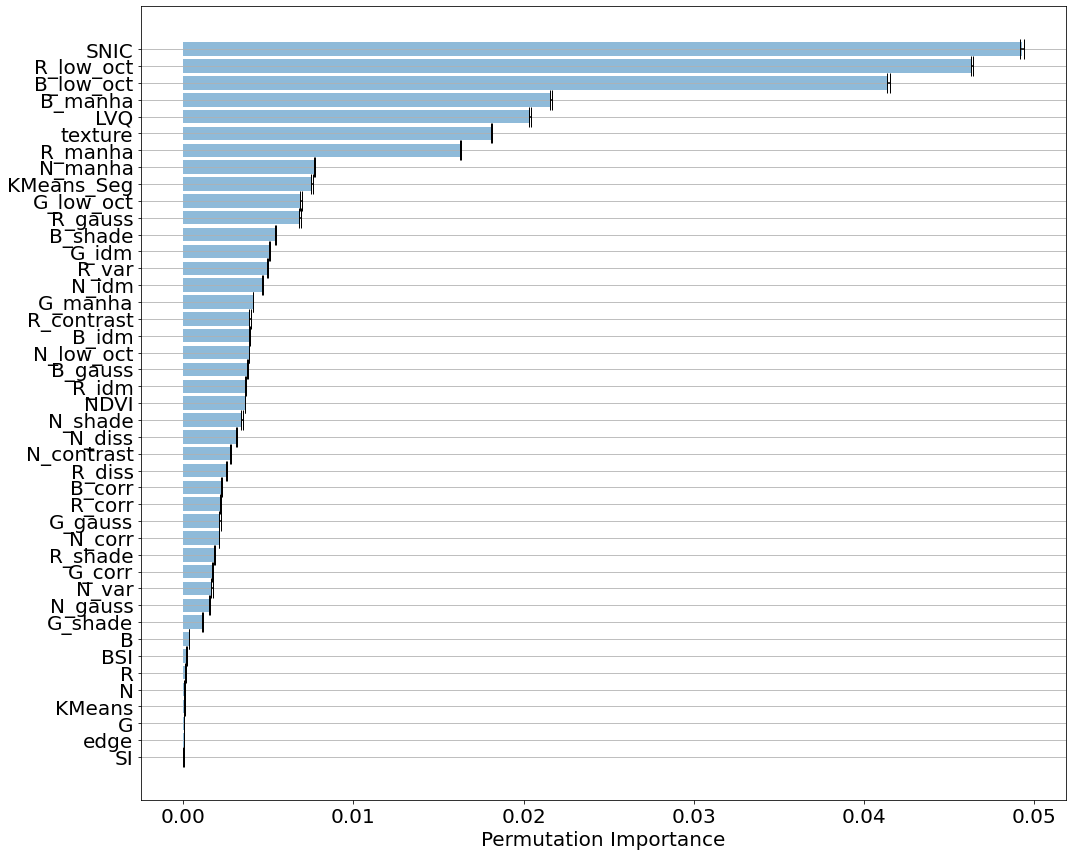

In [0]:
col_name=np.array(train_X.columns.tolist())
imp=perm.feature_importances_
imp_std=perm.feature_importances_std_
x_pos = np.arange(len(col_name))
sort_ind=np.argsort(imp)
#sort_ind=np.argsort(imp)[::-1] #descending order
imp=imp[sort_ind]
imp_std=imp_std[sort_ind]
col_name=col_name[sort_ind]

# Build the plot
#plt.figure(figsize=(26,12))
fig, ax = plt.subplots()
ax.barh(x_pos, imp, xerr=imp_std, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_xlabel('Permutation Importance', fontsize=20)
ax.set_yticks(x_pos)
ax.set_yticklabels(col_name)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.yaxis.grid(True)
fig.set_size_inches(15, 12)
# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()

__Results Interpretation__
Showed as above, when evaluating local node purity of trees, the Gini calculations showed that SNIC segmentations are the most important feature differentiating building damage types. This makes sense as it implies the building grouping and is able to seperate background pixel and buildings. Texture metrics are some other important features when evaluated by Gini. However, when from a global perspective of the model, although SNIC is still the most important according to the permutation importance, other features influencing the overall accuracy were some layers filtered by some shape-related convolutional filters such as octagon filters or manhattan distance filters (mostly texture from red and green bands). Clusters from the LVQ segmentations have also been found important.

### Shapley Additive Explanations

In [0]:
import shap

In [0]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(gbc)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [0]:
# calculate shap values for all of val_X 
shap_values = explainer.shap_values(train_X,approximate=True)

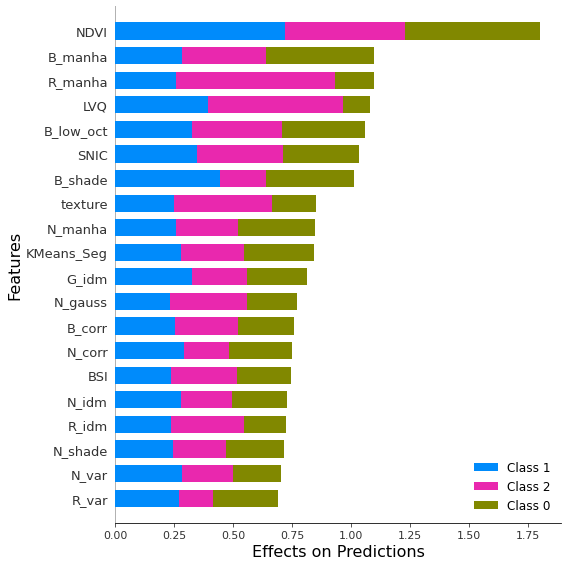

In [0]:
shap.summary_plot(shap_values, train_X, plot_type="bar",show=False)
ax = plt.gca()
ax.set_xlabel('Effects on Predictions', fontsize=16)
ax.set_ylabel('Features', fontsize=16)
#ax.set_xlim(-200,200)
plt.show()

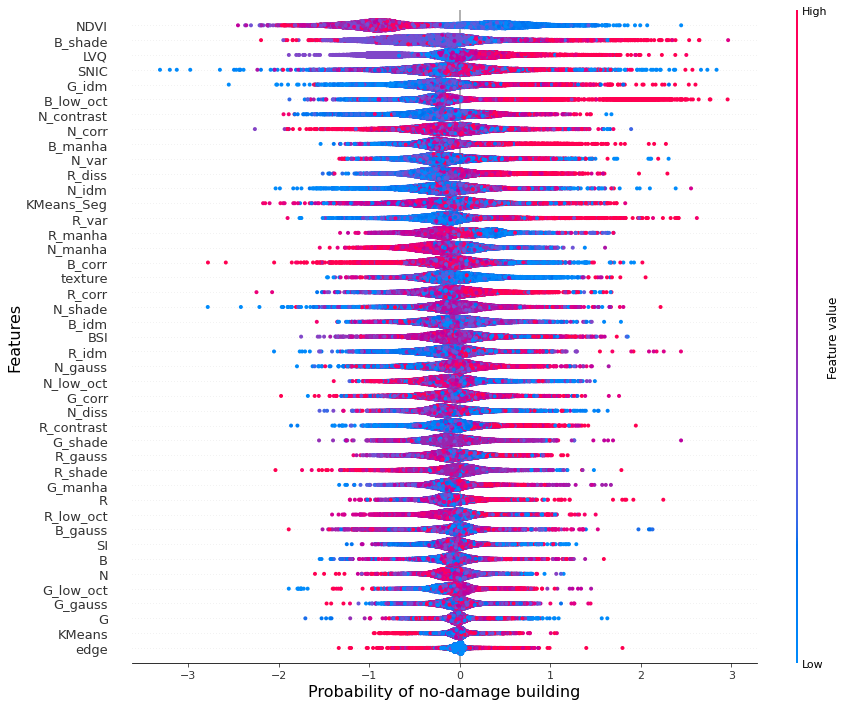

In [0]:
# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], train_X,max_display=45,show=False)
fig = plt.gcf()
fig.set_figheight(12)
fig.set_figwidth(14)
ax = plt.gca()
#ax.set_xlabel(r'durchschnittliche SHAP Werte $\vert\sigma_{ij}\vert$', fontsize=16)
ax.set_xlabel('Probability of no-damage building', fontsize=16)
ax.set_ylabel('Features', fontsize=16)
#ax.set_xlim(-200,200)
plt.show()

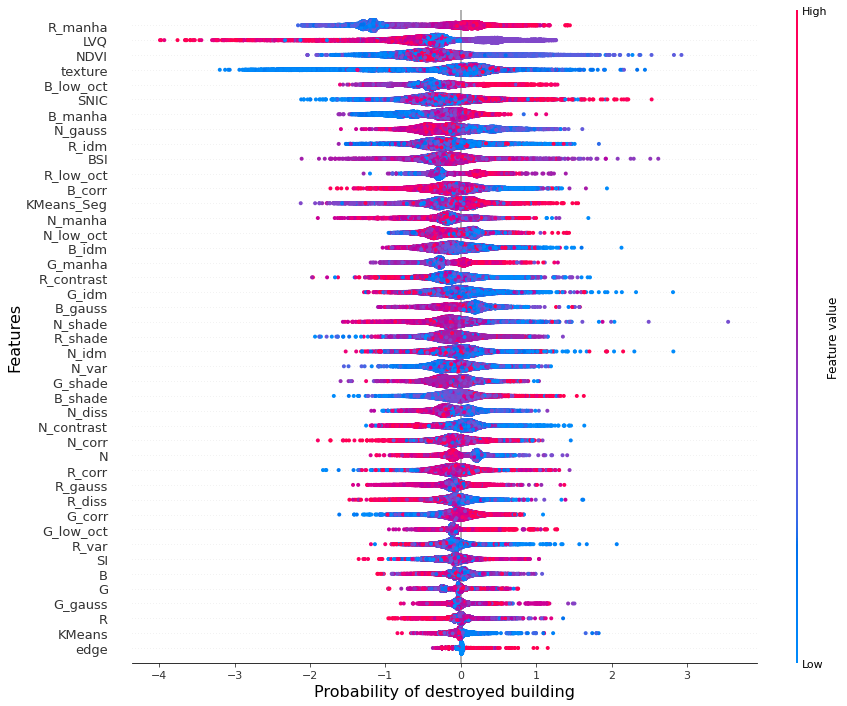

In [0]:
# Make plot. Index of [2] is explained in text below.
shap.summary_plot(shap_values[2], train_X,max_display=45,show=False)
fig = plt.gcf()
fig.set_figheight(12)
fig.set_figwidth(14)
ax = plt.gca()
#ax.set_xlabel(r'durchschnittliche SHAP Werte $\vert\sigma_{ij}\vert$', fontsize=16)
ax.set_xlabel('Probability of destroyed building', fontsize=16)
ax.set_ylabel('Features', fontsize=16)
#ax.set_xlim(-200,200)
plt.show()

In [0]:
shap.initjs()
#shap.force_plot is slow for many thousands of rows, try subsampling data
shap_force=shap.force_plot(explainer.expected_value[1], shap_values[1][:900,:], train_X.iloc[:900,:])

__Feature Analysis__
SHAP values indicate that for one prediction data point, the amount of increase/decrease of the predicted value from the baseline value by taking the current feature value into the model. According to SHAP values, NDVI values influences predicted values most when compared with the baseline values. Its effect is stronger on the no-damage building predictions than the other two classes. Normally, pixels with low NDVI values would be less likely to be no-damage buildings. For destroyed buildlings, red reflection filtered by manhattan filters and LVQ clusters would have higher effects on its predicted values.  